In [89]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
dataset = pd.read_csv('train_LZdllcl.csv',index_col = 0)
dataset.head()

<IPython.core.display.Javascript object>

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [94]:
dataset.shape

(54808, 13)

In [95]:
dataset['is_promoted'].value_counts()/dataset.shape[0]*100

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64

### **Clearly an imbalanced dataset**

In [96]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.9+ MB


In [97]:
dataset.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

**We will analyze these null values and find a method to handle it**

In [98]:
categorical_cols = [col for col in dataset.columns if dataset[col].dtypes=='O']
categorical_cols

['department', 'region', 'education', 'gender', 'recruitment_channel']

**<span style = 'color:red'>Region</span> of a person should not be considered as a feature even if its correlation with the output feature is high to decide his/her promotion because understand that a person coming from a certain area has no relation with his or her promotion and if that person has other great qualities and performances across the years but lets say other people coming from that particular region may not have good performance then he will also be impacted as our model will become biased due to this and will lead to incorrect predictions.**

In [99]:
dataset[categorical_cols].nunique()

department              9
region                 34
education               3
gender                  2
recruitment_channel     3
dtype: int64

In [100]:
numerical_cols = [col for col in dataset.columns if dataset[col].dtypes!='O']
numerical_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'is_promoted']

In [101]:
dataset[numerical_cols].nunique()

no_of_trainings         10
age                     41
previous_year_rating     5
length_of_service       35
KPIs_met >80%            2
awards_won?              2
avg_training_score      61
is_promoted              2
dtype: int64

In [102]:
dataset['no_of_trainings'].value_counts()

1     44378
2      7987
3      1776
4       468
5       128
6        44
7        12
8         5
9         5
10        5
Name: no_of_trainings, dtype: int64

**From this observation we infer that <span style="color:green">KPIs_met >80%,  awards_won?,  previous_year_rating</span> are discrete numerical variables while <span style='color:blue'>no_of_trainings</span> has most of the values ranging from 1 to 4 so for trainings more than 4 we can replace it to with a <span style='color:violet'>'rare/more_trained'</span> feature .**

In [103]:
discrete_cols = ['KPIs_met >80%','awards_won?','previous_year_rating','no_of_trainings']
discrete_cols

['KPIs_met >80%', 'awards_won?', 'previous_year_rating', 'no_of_trainings']

In [104]:
continuous_cols = [col for col in numerical_cols if col not in discrete_cols and col!='is_promoted']
continuous_cols

['age', 'length_of_service', 'avg_training_score']

## Let's replace the NaN value with 'Missing' so as to see some relationship with output variable

In [105]:
def nan_replacer(dataset_missing,features):
    
    for feature in features:
        
        dataset_missing[feature] = np.where(dataset_missing[feature].isnull(),'Missing',dataset_missing[feature])
        
        
    return dataset_missing

In [106]:
dataset_missing = nan_replacer(dataset.copy(),['education','previous_year_rating'])

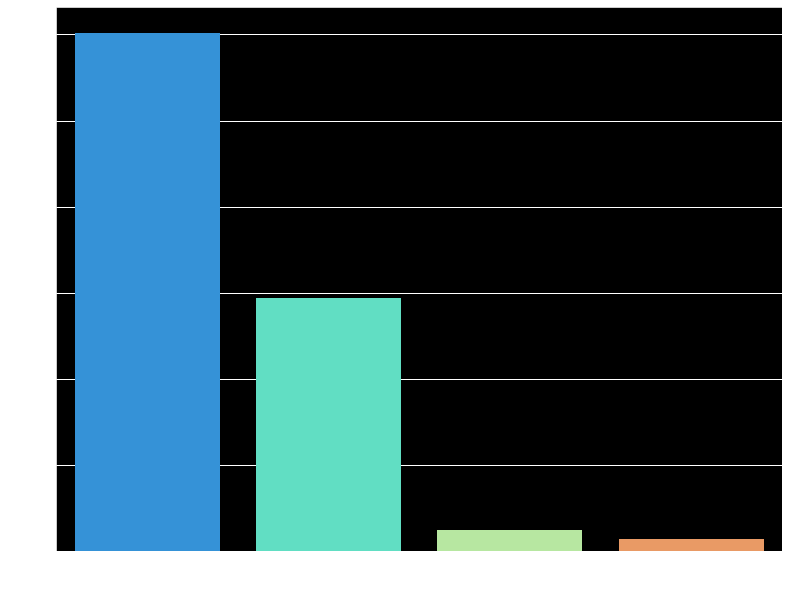

In [107]:
plt.figure(figsize=[13,10])
plt.style.use('dark_background')
sns.countplot(dataset_missing[dataset_missing.is_promoted==1].education,palette='rainbow')
plt.ylabel('are_promoted')
plt.show()

### <span style='color:red'> We will impute it with the mode of that feature ie; <span style='color:purple'> "Bachelor's" </span> here.

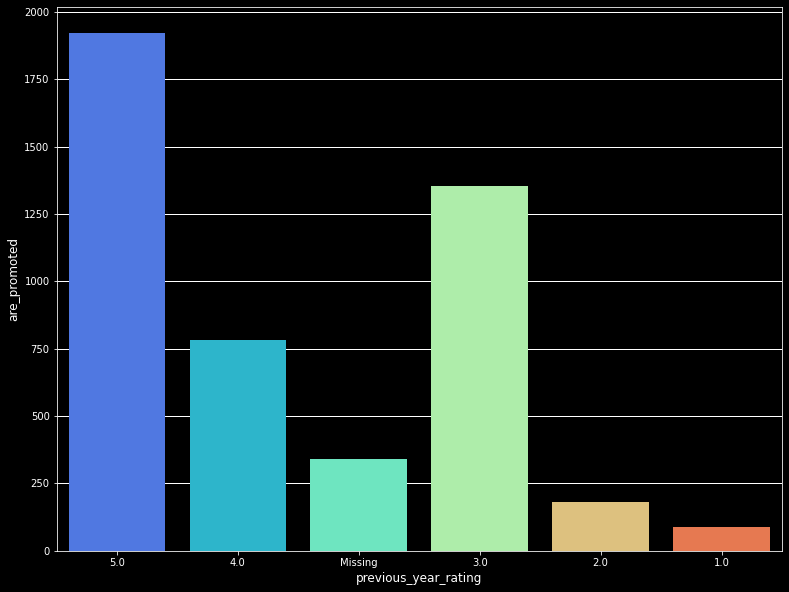

In [108]:
plt.figure(figsize=[13,10])
plt.style.use('dark_background')
sns.countplot(dataset_missing[dataset_missing.is_promoted==1].previous_year_rating,palette='rainbow')
plt.ylabel('are_promoted')
plt.show()

### <span style='color:red'> As this is a discrete numerical feature we will impute it with the median of the column.

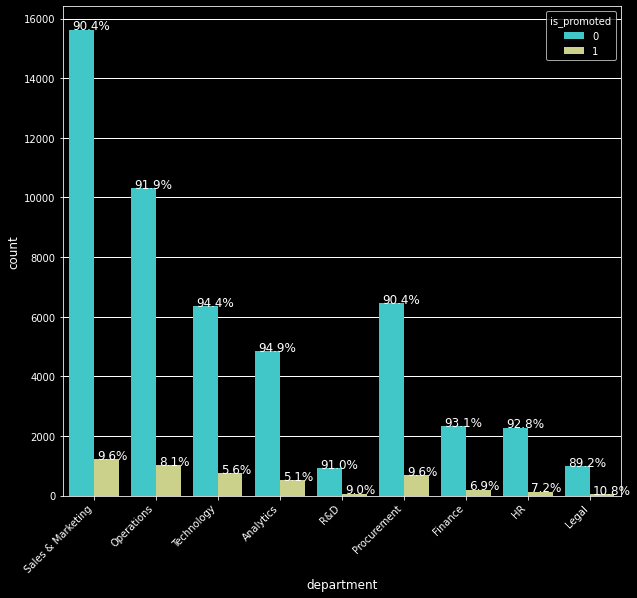

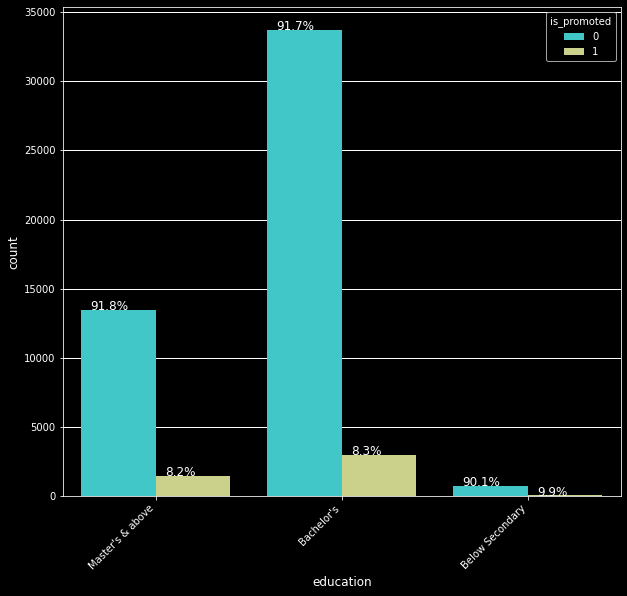

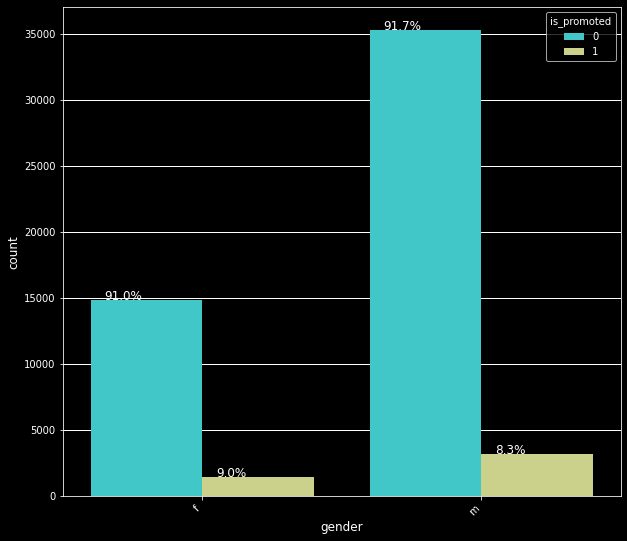

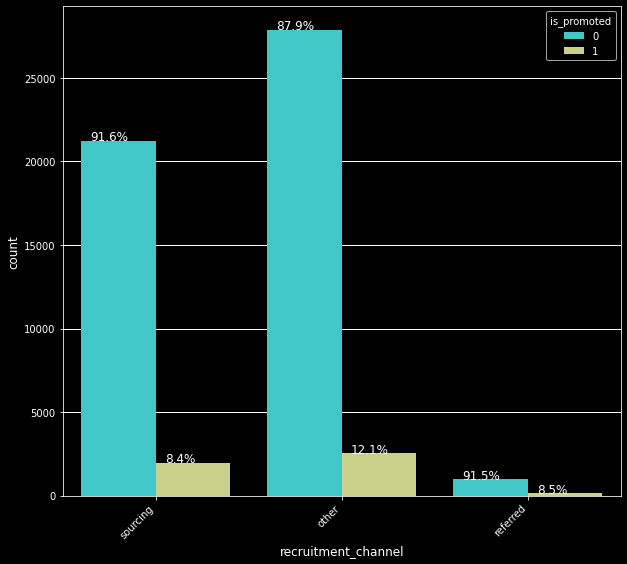

In [109]:

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    
    for i in range(Number_of_categories):
        total = dataset.groupby(feature)[feature].value_counts()[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * dataset.groupby(feature)['is_promoted'].value_counts()[2*i+j]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 12)
    
    plt.show()

for col in categorical_cols:
    
    if col!='region':
        plt.style.use('dark_background') 
        plt.figure(figsize=[10,9])
        plot = sns.countplot(x=dataset[col],hue = dataset['is_promoted'],palette='rainbow')
        plt.xticks(rotation=45,ha='right')
        with_hue(plot,col,dataset[col].nunique(),2)

**<span style = 'color:purple'>The Analysis shows us the following things :- </span>**
<br> <br />

1. For a person to get promoted higher <span style = 'color:red'>**eduction**</span> is not quite influential.
<br> <br />
2. <span style = 'color:red'>**Recruitment_channel**</span> does not help with a person's promotion so they have fair chances.



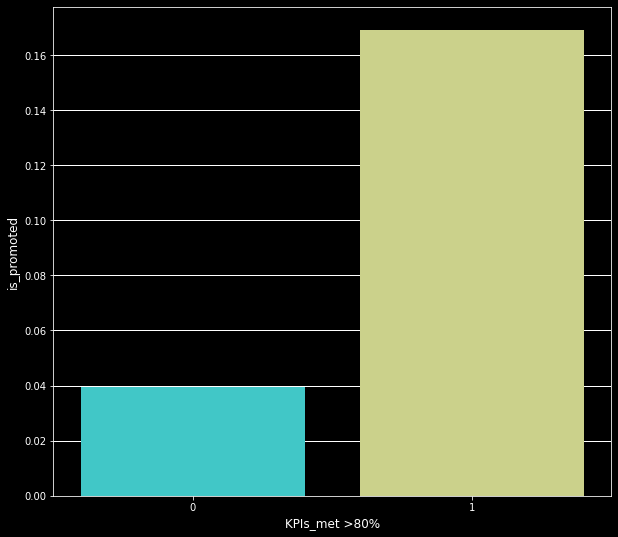

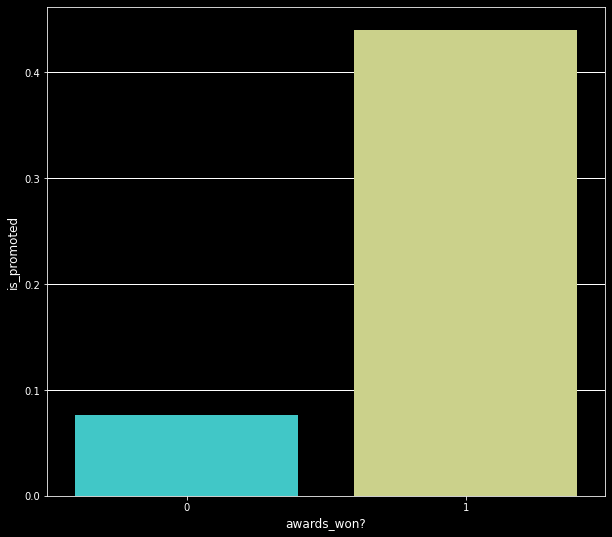

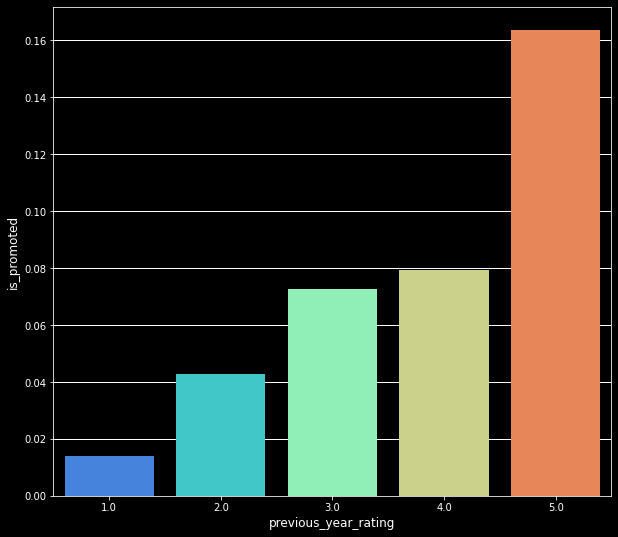

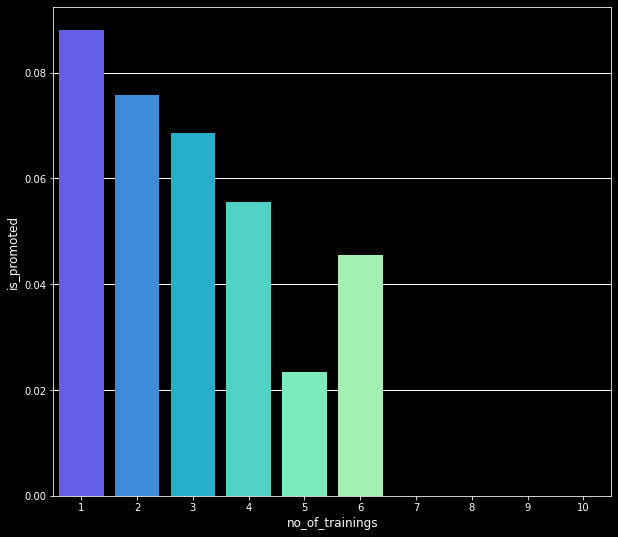

In [110]:
for col in discrete_cols:
    plt.style.use('dark_background') 
    plt.figure(figsize=[10,9])
    sns.barplot(x=col,data=dataset,y='is_promoted',palette='rainbow',ci=None)
    plt.show()

**<span style = 'color:violet'>The trend is clear to us :-</span>**
<br> <br /> 
<span style = 'color:red'>1. People who have won awards are likely to get promoted.</span><br> <br />
<span style = 'color:blue'>2. People who have a KPI score of more than 80% are likely to get promoted.</span><br> <br />
<span style = 'color:green'>3. People having higher rating have higher chances of getting a promotion.</span><br> <br />

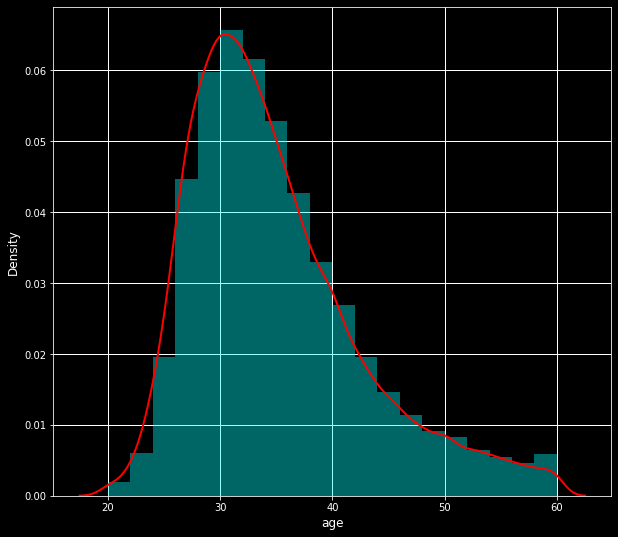

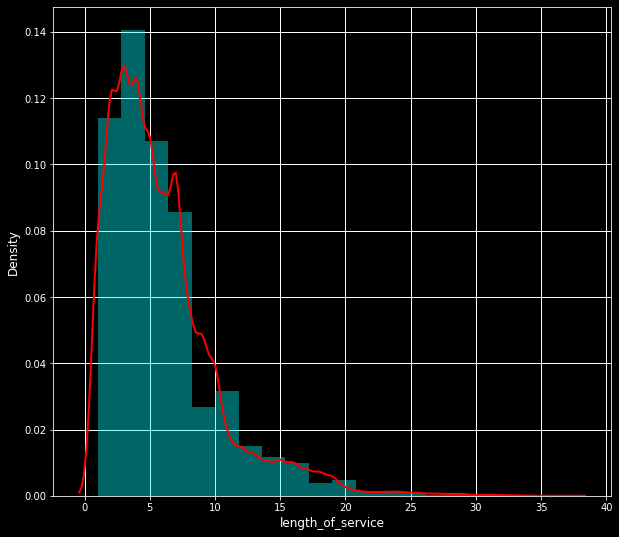

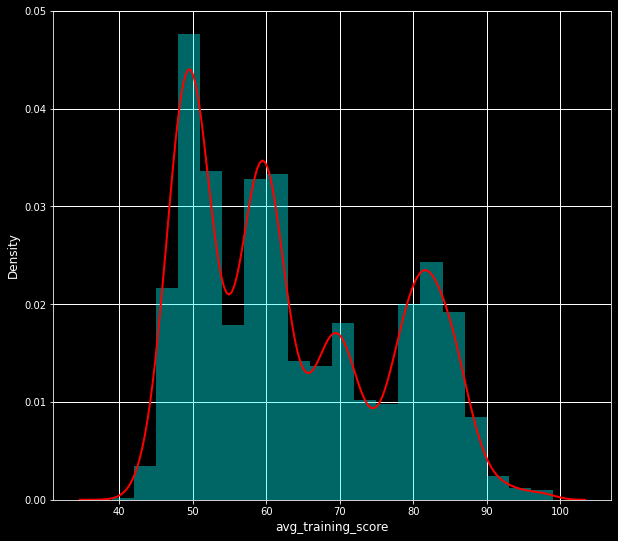

In [111]:
for col in continuous_cols:
    plt.style.use('dark_background') 
    plt.figure(figsize=[10,9])
    sns.distplot(dataset[col],bins=20,color='cyan',kde_kws={"color":"red"},kde=True)
    plt.show()

**<span style='color:red'> Observations :- </span>**
<br> <br />
<span style='color:darkorange'> 1. <span style='color:blue'>Age</span> and <span style='color:blue'>length_of_service</span> are right skewed distributions.
<br> <br /> 
<span style='color:darkorange'> 2. <span style='color:blue'>no._of_trainings</span> taken by individuals sharply decreases from 1 to 10.

<span style='color:darkorange'> 3. <span style='color:blue'>avg_training_score</span> has a peak initially but it decreases non-uniformly upto a score of 80 and an increase is noted after it however the graph declines uniformly after that.

**Lets try to Handle the distribution and see if we can do something**

In [113]:
for col in continuous_cols:
    print('{} has {} skewness'.format(col,dataset[col].skew()))

age has 1.0074317710382241 skewness
length_of_service has 1.738061458740809 skewness
avg_training_score has 0.45190808551707995 skewness


In [114]:
def transformers(data,cols):
    print('**Log Transformation**')
    for col in cols:
        transformed_data = np.log(data[col])
        print('{} has {:.2f} skewness'.format(col,transformed_data.skew()))
    print('\n\n')
    print('**BoxCox Transformation**')
    for col in cols:
        transformed_data = stats.boxcox(data[col])[0]
        print('{} has {:.2f} skewness'.format(col,stats.skew(transformed_data)))
        
    print('\n\n')
    print('**Square Root Transformation**')
    for col in cols:
        transformed_data = data[col]**(1/2)
        print('{} has {:.2f} skewness'.format(col,transformed_data.skew()))
        
    print('\n\n')
    print('**Cube Root Transformation**')
    for col in cols:
        transformed_data = data[col]**(1/3)
        print('{} has {:.2f} skewness'.format(col,transformed_data.skew()))
        
    print('\n\n')

In [115]:
transformers(dataset,continuous_cols)

**Log Transformation**
age has 0.48 skewness
length_of_service has -0.29 skewness
avg_training_score has 0.22 skewness



**BoxCox Transformation**
age has 0.02 skewness
length_of_service has -0.01 skewness
avg_training_score has 0.06 skewness



**Square Root Transformation**
age has 0.74 skewness
length_of_service has 0.66 skewness
avg_training_score has 0.34 skewness



**Cube Root Transformation**
age has 0.66 skewness
length_of_service has 0.33 skewness
avg_training_score has 0.30 skewness





**<span style = 'color:violet'> It is pretty clear that we need to use BoxCox Transformation for better results</span>**

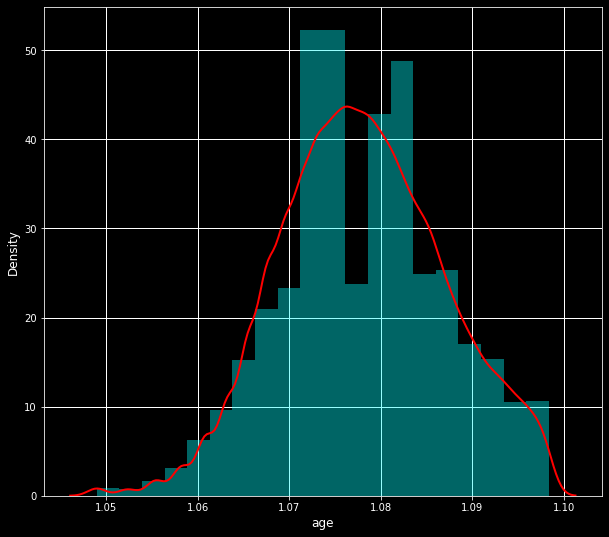

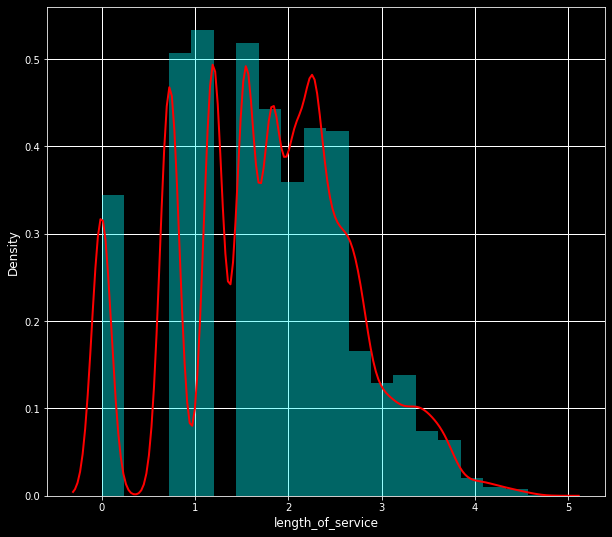

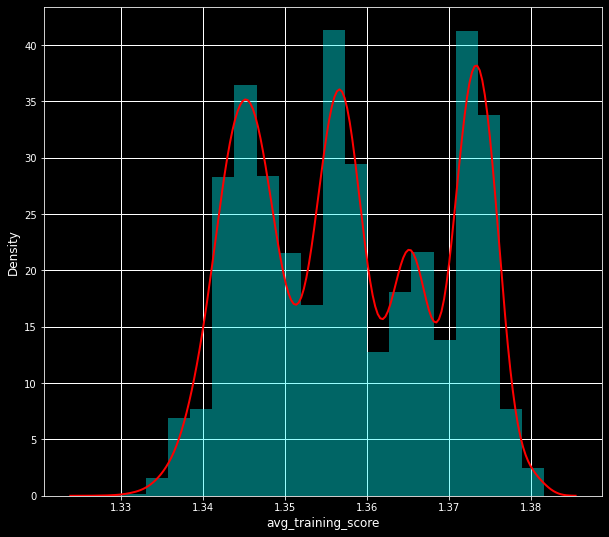

In [116]:
for col in continuous_cols:
    if 0 not in dataset[col]:
        plt.style.use('dark_background') 
        plt.figure(figsize=[10,9])
        sns.distplot(stats.boxcox(dataset[col])[0],bins=20,color='cyan',kde_kws={'color':'red'})
        plt.xlabel(col)
        plt.show()


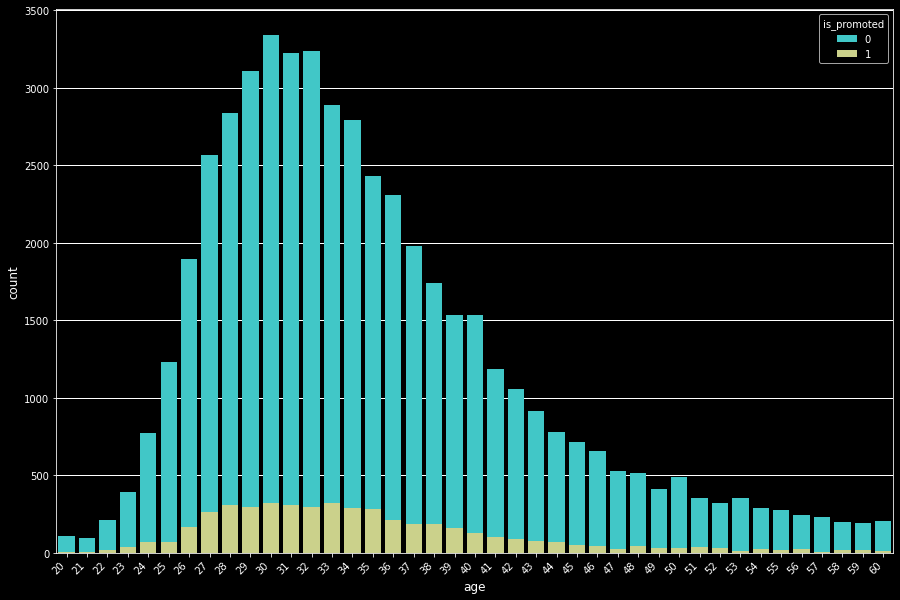

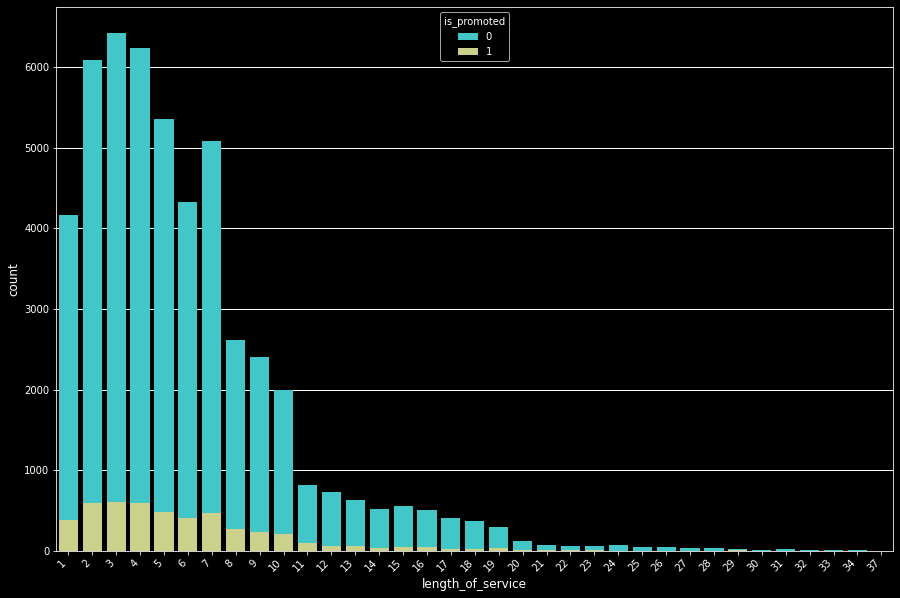

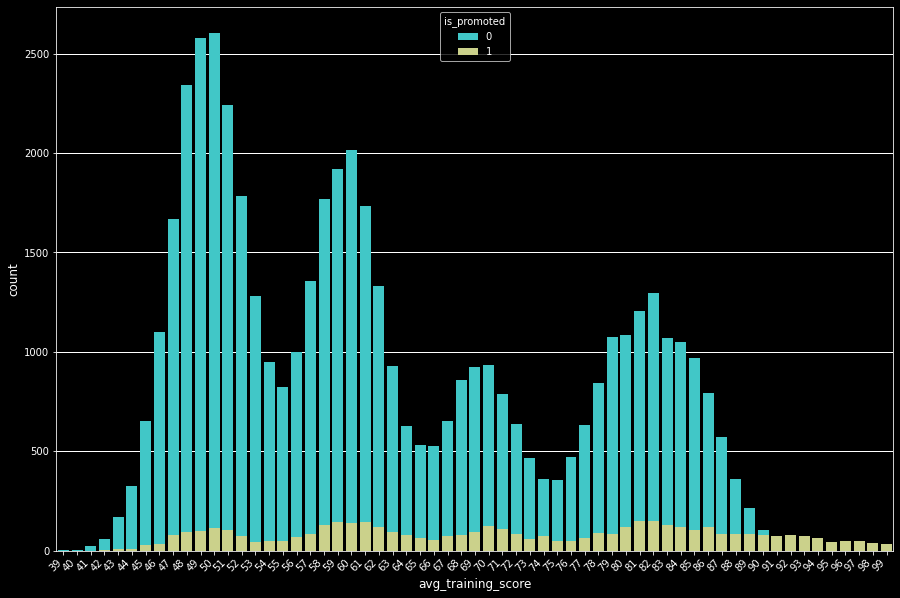

In [117]:
for col in continuous_cols:
    plt.figure(figsize=[15,10])
    plt.style.use('dark_background') 
    sns.countplot(x=dataset[col],hue=dataset['is_promoted'],palette='rainbow',dodge=False)
    plt.xticks(rotation=45,ha='right')
    plt.show()

**We can see that :-**
<br> <br />
<span style='color:red'>1. Employees who have higher length of service are less promoted because they might be already at a high position </span>
<br> <br />
<span style='color:green'>2. Age of an employee follows a right skewed distribution but the skewness is less. </span>
<br> <br />
<span style='color:blue'>3. Employees who have less trainings for a specific course are less selected. </span>
<br> <br />
<span style='color:darkorange'>4. Average training score of the employees who are promoted follows a periodic gaussian distribution and right skewed distribution at the last and also employees are getting promoted at a very high rate if their score is atleast . </span>
<br> <br />

**Now we will see for the outliers in continuous numerical variables**

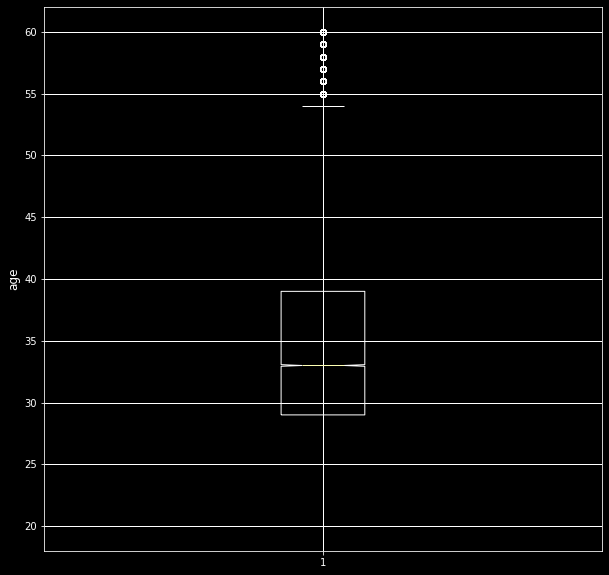

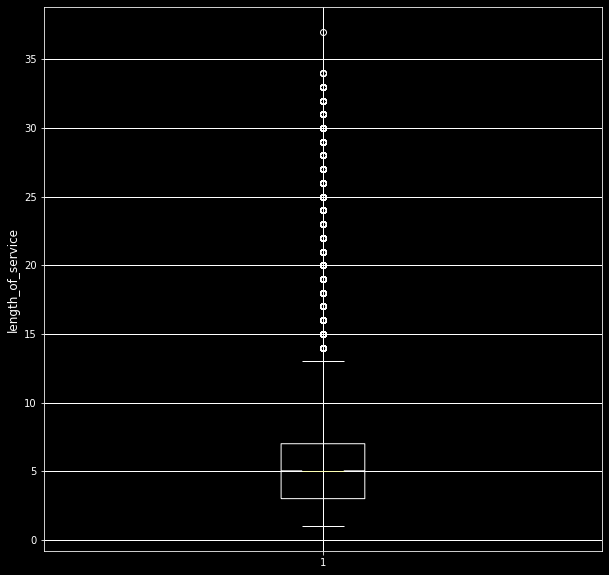

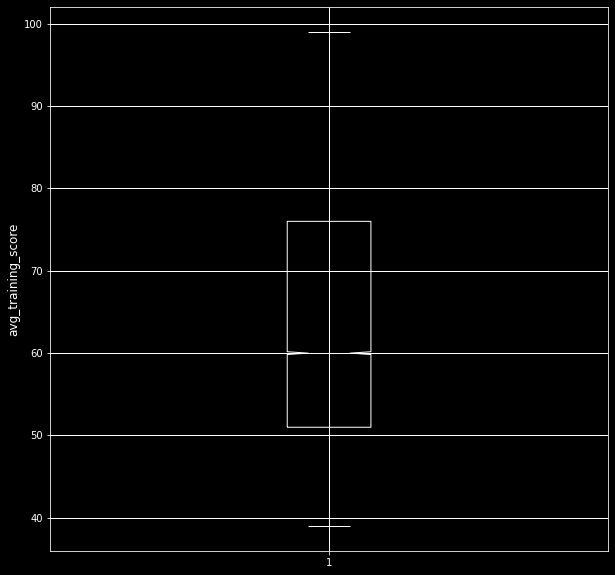

In [118]:
for col in continuous_cols:
    plt.style.use('dark_background')
    plt.figure(figsize=[10,10])
    plt.boxplot(x=col,data=dataset,notch=True)
    plt.ylabel(col)
    plt.show()

**Presumably age and length_of_service columns has outliers lets see a more detailed summary of those two columns**

In [119]:
dataset['age'].describe()

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

### <span style='color:green'>Understand that Age column here is a bit right skewed but we can treat it as a gaussian distribution as the outlier values are not that extreme</span>

#### For that we will remove the values above 3rd deviation from both ends in feature engineering

In [120]:
upper_limit_age = dataset['age'].mean() + dataset['age'].std()*3
lower_limit_age = dataset['age'].mean() - dataset['age'].std()*3
lower_limit_age,upper_limit_age

(11.82340788203259, 57.784423091547914)

**As min value for age is 20 so lower_limit is satisfied**
<br> <br />
**For upper_limit we will remove the outliers having age above 57**

In [121]:
dataset['length_of_service'].describe()

count    54808.000000
mean         5.865512
std          4.265094
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         37.000000
Name: length_of_service, dtype: float64

### <span style='color:purple'>Understand that length_of_service column here is a right skewed distribution so we need to use IQR method to handle it and since it has extreme values as compared to rest of the data we will use 3*IQR </span>

In [122]:
IQR = dataset.length_of_service.quantile(0.75) - dataset.length_of_service.quantile(0.25)
upper_limit_service = dataset.length_of_service.quantile(0.75) + 3*IQR
lower_limit_service = dataset.length_of_service.quantile(0.25) - 3*IQR
lower_limit_service,upper_limit_service

(-9.0, 19.0)

**-9 doesn't make any sense so employees having more than 19 years of experience are outliers and will be handled**

## <span style='color:red'>One thing to keep in mind that these outliers will be handled for outlier-sensitive algorithms and not for the algorithms which are robust to it. </span>

<AxesSubplot:>

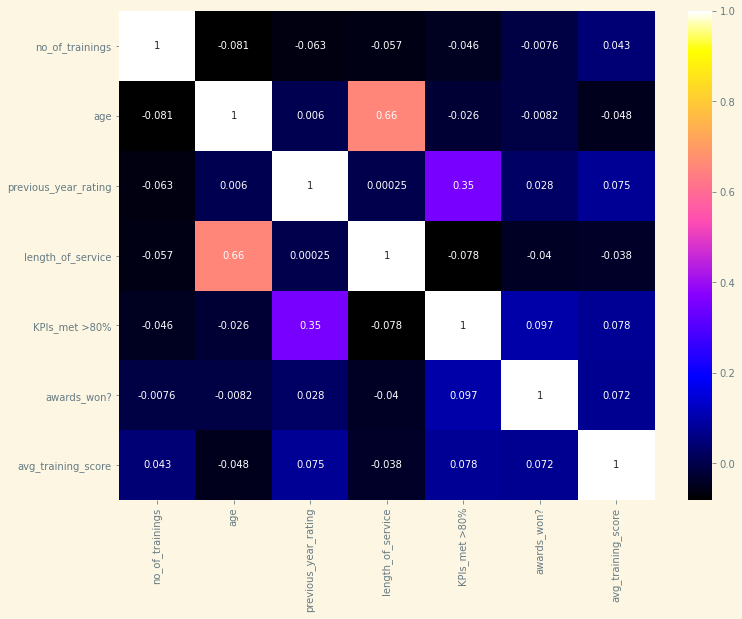

In [123]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=[12,9])
sns.heatmap(data=dataset.drop('is_promoted',axis=1).corr(),cmap=plt.cm.gnuplot2,annot=True)

**It is quite evident that length_of_service and age will have correlation**

In [124]:
dataset[['age','length_of_service']].corr()
## Not that of a high value so we can take both 

,age,length_of_service
age,1.000000,0.657111
length_of_service,0.657111,1.000000


## To prevent Data leakage use train-test-split before any feature engineering

In [132]:
from sklearn.model_selection import train_test_split
train,validation = train_test_split(dataset,test_size=0.25,random_state=42)

##  <span style='color:indigo'>Lets start the feature engineering now. We will do it for validation simultaneously </span>

### Checklist

- [ ] <span style='color:slateblue'> **Removing Region column** </span>
- [ ] <span style='color:slateblue'> **Handling missing values** </span>
- [ ] <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- [ ] <span style='color:slateblue'> **Handling the categorical columns** </span>
- [ ] <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>



In [133]:
X_train = train.drop('is_promoted',axis=1)
y_train = train.is_promoted

In [134]:
X_val = validation.drop('is_promoted',axis=1)
y_val = validation.is_promoted

In [135]:
X_train = X_train.drop('region',axis=1)
X_val = X_val.drop('region',axis=1)
print(X_train.columns)

Index(['department', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'],
      dtype='object')


- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- [ ] <span style='color:slateblue'> **Handling missing values** </span>
- [ ] <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- [ ] <span style='color:slateblue'> **Handling the categorical columns** </span>
- [ ] <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>


In [136]:
X_train.previous_year_rating.median(skipna=True),X_val.previous_year_rating.median(skipna=True)

(3.0, 3.0)

In [137]:
X_train['education'] = np.where(X_train['education'].isnull() , "Bachelor's" ,X_train['education'])
X_train['previous_year_rating'] = np.where(X_train['previous_year_rating'].isnull() , X_train.previous_year_rating.median(skipna=True),
                                     X_train['previous_year_rating'])
X_train.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
employee_id,,,,,,,,,,,
59283,Sales & Marketing,Bachelor's,m,other,1,25,3.0,1,0,1,50
37987,Operations,Bachelor's,f,other,2,35,1.0,9,0,0,55
48952,Technology,Master's & above,f,sourcing,1,39,4.0,9,0,0,80
15864,HR,Bachelor's,f,other,1,26,3.0,3,0,0,47
41474,Operations,Bachelor's,f,other,1,25,3.0,1,1,0,62


In [138]:
X_val['education'] = np.where(X_val['education'].isnull() , "Bachelor's" ,X_val['education'])
X_val['previous_year_rating'] = np.where(X_val['previous_year_rating'].isnull() , X_val.previous_year_rating.median(skipna=True),
                                     X_val['previous_year_rating'])

In [139]:
X_train.isnull().sum()

department              0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- [ ] <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- [ ] <span style='color:slateblue'> **Handling the categorical columns** </span>
- [ ] <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>


In [141]:
X_train['no_of_trainings'] = np.where(X_train['no_of_trainings']>4,'more_trainings',X_train['no_of_trainings'])
X_train['no_of_trainings'].value_counts()

1                 33227
2                  6020
3                  1349
4                   360
more_trainings      150
Name: no_of_trainings, dtype: int64

In [142]:
X_val['no_of_trainings'] = np.where(X_val['no_of_trainings']>4,'more_trainings',X_val['no_of_trainings'])

- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- ✅ <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- [ ] <span style='color:slateblue'> **Handling the categorical columns** </span>
- [ ] <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>


In [143]:
categorical_cols.remove('region')
categorical_cols

['department', 'education', 'gender', 'recruitment_channel']

In [144]:
## We are not taking region column
for col in categorical_cols:
    X_train = pd.get_dummies(data=X_train,columns=[col],drop_first=True)

X_train.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
employee_id,,,,,,,,,,,,,,,,,,,,
59283,1,25,3.0,1,0,1,50,0,0,0,0,0,0,1,0,0,0,1,0,0
37987,2,35,1.0,9,0,0,55,0,0,0,1,0,0,0,0,0,0,0,0,0
48952,1,39,4.0,9,0,0,80,0,0,0,0,0,0,0,1,0,1,0,0,1
15864,1,26,3.0,3,0,0,47,0,1,0,0,0,0,0,0,0,0,0,0,0
41474,1,25,3.0,1,1,0,62,0,0,0,1,0,0,0,0,0,0,0,0,0


In [145]:
for col in categorical_cols:
    X_val = pd.get_dummies(data=X_val,columns=[col],drop_first=True)


- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- ✅ <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- ✅ <span style='color:slateblue'> **Handling the categorical columns** </span>
- [ ] <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>


In [146]:
## Here we will change the no_of_trainings column to be one hot-encoded as other discrete columns has numerical features
X_train = pd.get_dummies(X_train,columns=['no_of_trainings'],drop_first=True)
X_train.head()

,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,no_of_trainings_2,no_of_trainings_3,no_of_trainings_4,no_of_trainings_more_trainings
employee_id,,,,,,,,,,,,,,,,,,,,,,,
59283,25,3.0,1,0,1,50,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
37987,35,1.0,9,0,0,55,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
48952,39,4.0,9,0,0,80,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
15864,26,3.0,3,0,0,47,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41474,25,3.0,1,1,0,62,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [147]:
X_val = pd.get_dummies(X_val,columns=['no_of_trainings'],drop_first=True)

- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- ✅ <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- ✅ <span style='color:slateblue'> **Handling the categorical columns** </span>
- ✅ <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- [ ] <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>

In [148]:
continuous_cols

['age', 'length_of_service', 'avg_training_score']

In [149]:
X_train['age'],lambda_age = stats.boxcox(X_train['age'])
X_train['length_of_service'],lambda_los = stats.boxcox(X_train['length_of_service'])
X_train['avg_training_score'],lambda_ats = stats.boxcox(X_train['avg_training_score'])
X_train.head()

,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,no_of_trainings_2,no_of_trainings_3,no_of_trainings_4,no_of_trainings_more_trainings
employee_id,,,,,,,,,,,,,,,,,,,,,,,
59283,1.054235,3.0,0.000000,0,1,1.354674,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
37987,1.070506,1.0,2.604660,0,0,1.360923,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
48952,1.074780,4.0,2.604660,0,0,1.381873,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
15864,1.056393,3.0,1.194779,0,0,1.350393,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41474,1.054235,3.0,0.000000,1,0,1.368217,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## We need these lamda value to transform our validation and test data and also the data that will come in model deployment

In [150]:
lambda_age,lambda_los,lambda_ats

(-0.8954292589741352, 0.15068452050094655, -0.6881862165452892)

In [151]:
lambda_dict = {'age':lambda_age,'length_of_service':lambda_los,'avg_training_score':lambda_ats}

In [152]:
import pickle
pickle.dump(lambda_dict,open('lamda_values.pkl','wb'),protocol=pickle.HIGHEST_PROTOCOL)

## <span style='color:green'>BoxCox Transformation Formula
![BoxCox Transformation Formula](boxcox.png)

In [153]:
## As lambda is non-zero we will apply first formula
X_val['age'] = (X_val['age']**lambda_dict['age'] - 1)/lambda_dict['age']
X_val['length_of_service'] = (X_val['length_of_service']**lambda_dict['length_of_service'] - 1)/lambda_dict['length_of_service']
X_val['avg_training_score'] = (X_val['avg_training_score']**lambda_dict['avg_training_score'] - 1)/lambda_dict['avg_training_score']
X_val.head()

,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,no_of_trainings_2,no_of_trainings_3,no_of_trainings_4,no_of_trainings_more_trainings
employee_id,,,,,,,,,,,,,,,,,,,,,,,
5599,1.070506,5.0,2.752543,0,0,1.350393,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
73176,1.068002,1.0,1.541719,0,0,1.356007,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
13157,1.073791,3.0,2.888358,0,0,1.370052,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
7458,1.068002,1.0,2.442096,0,0,1.362059,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
28446,1.072752,1.0,1.541719,0,0,1.381873,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- ✅ <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- ✅ <span style='color:slateblue'> **Handling the categorical columns** </span>
- ✅ <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- ✅ <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- [ ] <span style='color:slateblue'> **Handling in imbalanced data.** </span>

In [154]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)
X_train,y_train = smk.fit_resample(X_train,y_train)

- ✅ <span style='color:slateblue'> **Removing Region column** </span>
- ✅ <span style='color:slateblue'> **Handling missing values** </span>
- ✅ <span style='color:slateblue'> **Changing the no_of_trainings column** </span>
- ✅ <span style='color:slateblue'> **Handling the categorical columns** </span>
- ✅ <span style='color:slateblue'> **Handling the discrete_numerical columns** </span>
- ✅ <span style='color:slateblue'> **BoxCox Transformation of continuous columns to reduce skewness** </span>
- ✅ <span style='color:slateblue'> **Handling in imbalanced data.** </span>

In [155]:
X_train.to_csv('Preprocessed_X_train')
y_train.to_csv('Preprocessed_y_train')
X_val.to_csv('Preprocessed_X_test')
y_val.to_csv('Preprocessed_y_test')

In [5]:
X_train = pd.read_csv('Preprocessed_X_train',index_col=0,low_memory=False)
y_train = pd.read_csv('Preprocessed_y_train',index_col=0,low_memory=False)
X_train.shape,y_train.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

((73064, 23), (73064, 1))

In [12]:
X_val = pd.read_csv('Preprocessed_X_test',index_col=0,low_memory=False)
y_val = pd.read_csv('Preprocessed_y_test',index_col=0,low_memory=False)
X_val.shape,y_val.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

((13702, 23), (13702, 1))

In [6]:
X_train.head()

,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Finance,department_HR,department_Legal,department_Operations,...,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing,no_of_trainings_2,no_of_trainings_3,no_of_trainings_4,no_of_trainings_more_trainings
0,1.054235,3.0,0.000000,0,1,1.354674,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.070506,1.0,2.604660,0,0,1.360923,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1.074780,4.0,2.604660,0,0,1.381873,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,1.056393,3.0,1.194779,0,0,1.350393,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.054235,3.0,0.000000,1,0,1.368217,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train.value_counts()

is_promoted
0              36532
1              36532
dtype: int64

## <span style='color:orange'> As this data is quite huge to reduce training time we will use a sample of data to train the model but fit the complete dataset.

In [8]:
processed_data = pd.concat([X_train,y_train],axis=1).sample(frac=0.2,random_state=42)
processed_data.shape

<IPython.core.display.Javascript object>

(14613, 24)

In [9]:
processed_data['is_promoted'].value_counts()

0    7326
1    7287
Name: is_promoted, dtype: int64

In [10]:
X_sample = processed_data.drop('is_promoted',axis=1)
y_sample = processed_data['is_promoted']

### Balanced Data

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import  XGBClassifier
from sklearn.naive_bayes import  GaussianNB
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [164]:
def modelpicker(models):
  summary = {}
  for i in models:
    f1_score = cross_val_score(i,X_sample,y_sample,scoring='f1',cv=3,n_jobs=-1).mean()
    summary[str(i)] = f1_score
    print('\n',str(i),' : ',f1_score)
  return summary

In [165]:
models = [RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier(),
          DecisionTreeClassifier(),CatBoostClassifier(iterations=500),
          GaussianNB(),KNeighborsClassifier()]
model_acc = modelpicker(models)


 RandomForestClassifier()  :  0.8926886726146036

 AdaBoostClassifier()  :  0.8077240380891012

 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)  :  0.9583787018832767

 DecisionTreeClassifier()  :  0.8902234659657632

 <catboost.core.CatBoostClassifier object at 0x000002320EAA8A90>  :  0.9570815331507401

 GaussianNB()  :  0.6753281280974176

 KNeighborsClassifier()  :  0.7782032219729498


## <span style='color:purple'> It is pretty clear that XGBClassifier gives the best f1-score ie;<span style='color:red'> 0.9583787018832767 </span>so we will use that and hypertune it using optuna.

In [15]:
import optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',500,1500,100)
    learning_rate = trial.suggest_float('learning_rate',0.1,0.9,step=0.1)
    max_depth = trial.suggest_int('max_depth',3,20,1)
    min_child_weight = trial.suggest_int('min_child_weight',1,13,2)
    gamma = trial.suggest_float('gamma',0,0.6,step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.2,0.9,step=0.2)
    clf = XGBClassifier(n_estimators=n_estimators,learning_rate = learning_rate , max_depth = max_depth,
                        min_child_weight = min_child_weight , gamma = gamma,
                        colsample_bytree = colsample_bytree)
    return cross_val_score(clf,X_sample,y_sample,n_jobs=-1,cv = 3,scoring='f1').mean()

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 150)

[I 2021-07-22 23:58:00,623] A new study created in memory with name: no-name-3a9c357b-519f-4967-8d33-8862c972c8f6
[I 2021-07-22 23:58:22,255] Trial 0 finished with value: 0.955920883244962 and parameters: {'n_estimators': 1100, 'learning_rate': 0.7000000000000001, 'max_depth': 17, 'min_child_weight': 7, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.955920883244962.
[I 2021-07-22 23:58:43,145] Trial 1 finished with value: 0.951539687811339 and parameters: {'n_estimators': 1100, 'learning_rate': 0.9, 'max_depth': 11, 'min_child_weight': 11, 'gamma': 0.0, 'colsample_bytree': 0.6000000000000001}. Best is trial 0 with value: 0.955920883244962.
[I 2021-07-22 23:59:24,290] Trial 2 finished with value: 0.9565568475910924 and parameters: {'n_estimators': 1400, 'learning_rate': 0.9, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.4, 'colsample_bytree': 0.2}. Best is trial 2 with value: 0.9565568475910924.
[I 2021-07-22 23:59:49,929] Trial 3 finished with

[I 2021-07-23 00:05:19,676] Trial 28 finished with value: 0.9546237269601532 and parameters: {'n_estimators': 600, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.0, 'colsample_bytree': 0.6000000000000001}. Best is trial 7 with value: 0.9621308874898257.
[I 2021-07-23 00:05:34,783] Trial 29 finished with value: 0.955886006008701 and parameters: {'n_estimators': 1000, 'learning_rate': 0.5, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.2, 'colsample_bytree': 0.4}. Best is trial 7 with value: 0.9621308874898257.
[I 2021-07-23 00:06:13,850] Trial 30 finished with value: 0.9523229087301979 and parameters: {'n_estimators': 1300, 'learning_rate': 0.6, 'max_depth': 16, 'min_child_weight': 1, 'gamma': 0.1, 'colsample_bytree': 0.8}. Best is trial 7 with value: 0.9621308874898257.
[I 2021-07-23 00:06:20,927] Trial 31 finished with value: 0.9612136028577537 and parameters: {'n_estimators': 800, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_

[I 2021-07-23 00:11:28,289] Trial 57 finished with value: 0.9604917132508238 and parameters: {'n_estimators': 1100, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.8}. Best is trial 52 with value: 0.9621940360821749.
[I 2021-07-23 00:11:34,271] Trial 58 finished with value: 0.9600353342868684 and parameters: {'n_estimators': 700, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.2, 'colsample_bytree': 0.6000000000000001}. Best is trial 52 with value: 0.9621940360821749.
[I 2021-07-23 00:11:54,086] Trial 59 finished with value: 0.9545137260018907 and parameters: {'n_estimators': 1200, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.0, 'colsample_bytree': 0.8}. Best is trial 52 with value: 0.9621940360821749.
[I 2021-07-23 00:12:00,695] Trial 60 finished with value: 0.9609567632641656 and parameters: {'n_estimators': 900, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight':

[I 2021-07-23 00:17:46,445] Trial 86 finished with value: 0.9607900108277369 and parameters: {'n_estimators': 1500, 'learning_rate': 0.2, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.5, 'colsample_bytree': 0.2}. Best is trial 67 with value: 0.9622725358276919.
[I 2021-07-23 00:17:59,231] Trial 87 finished with value: 0.961064023077828 and parameters: {'n_estimators': 1500, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.6, 'colsample_bytree': 0.2}. Best is trial 67 with value: 0.9622725358276919.
[I 2021-07-23 00:18:15,678] Trial 88 finished with value: 0.9610830950968405 and parameters: {'n_estimators': 1400, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.5, 'colsample_bytree': 0.2}. Best is trial 67 with value: 0.9622725358276919.
[I 2021-07-23 00:18:36,266] Trial 89 finished with value: 0.9617084885499794 and parameters: {'n_estimators': 1500, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.6, 'colsample_

[I 2021-07-23 00:26:16,698] Trial 116 finished with value: 0.9605336276916788 and parameters: {'n_estimators': 1400, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.5, 'colsample_bytree': 0.2}. Best is trial 93 with value: 0.9623419169952938.
[I 2021-07-23 00:26:38,556] Trial 117 finished with value: 0.9630614090465907 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 117 with value: 0.9630614090465907.
[I 2021-07-23 00:26:50,107] Trial 118 finished with value: 0.9626804695656034 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 117 with value: 0.9630614090465907.
[I 2021-07-23 00:26:57,894] Trial 119 finished with value: 0.9626804695656034 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2, 'max_depth': 3, 'min_child

[I 2021-07-23 00:31:52,476] Trial 144 finished with value: 0.9626804695656034 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 117 with value: 0.9630614090465907.
[I 2021-07-23 00:32:05,245] Trial 145 finished with value: 0.9626752451930128 and parameters: {'n_estimators': 1100, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 117 with value: 0.9630614090465907.
[I 2021-07-23 00:32:18,617] Trial 146 finished with value: 0.9621088449668088 and parameters: {'n_estimators': 1000, 'learning_rate': 0.30000000000000004, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}. Best is trial 117 with value: 0.9630614090465907.
[I 2021-07-23 00:32:46,987] Trial 147 finished with value: 0.9629181830126115 and parameters: {'n_estimators': 900, 'learning_rate':

In [17]:
trial = study.best_trial
print('F1-Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

F1-Score: 0.9630614090465907
Best hyperparameters: {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.4}


## Train Accuracy is 96.306 %

In [18]:
clf = XGBClassifier(n_estimators=1000,learning_rate=0.1,
                    max_depth = 5, min_child_weight = 1,
                    gamma = 0.3, colsample_bytree = 0.4)
clf.fit(X_train,y_train)

[00:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
y_pred = clf.predict(X_val)

In [29]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
def evaluation(y_true,y_pred):
    print('Confusion Matrix : ','\n',confusion_matrix(y_true=y_true,y_pred=y_pred),'\n')
    print('Accuracy Score : ',accuracy_score(y_true=y_true,y_pred=y_pred),'\n')
    print('classification Report : ','\n',classification_report(y_true=y_true,y_pred=y_pred),'\n')

In [30]:
evaluation(y_val,y_pred)

Confusion Matrix :  
 [[12525    46]
 [  724   407]] 

Accuracy Score :  0.9438038242592323 

classification Report :  
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     12571
           1       0.90      0.36      0.51      1131

    accuracy                           0.94     13702
   macro avg       0.92      0.68      0.74     13702
weighted avg       0.94      0.94      0.93     13702
 



## Test Accuracy is 94.380 %

In [31]:
import pickle
pickle.dump(clf,open('model.pkl','wb'))